In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import chic

from astropy import units as u
from astropy import constants as C
from astropy.cosmology import Planck18
from tqdm.auto import tqdm

## Problem 2

Below is my perturbation code from HW6.

In [2]:
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

def dedim(x):
    return x.to(u.dimensionless_unscaled).value

class CCPP():
    """Connor's Cosmological Perturbation Program"""

    def __init__(self):
        self.O_b = Planck18.Ob0
        self.O_m = Planck18.Om0
        self.O_c = self.O_m - self.O_b
        self.O_L = Planck18.Ode0
        self.O_r = 1 - self.O_m - self.O_L
        self.O_g = Planck18.Ogamma0
        self.O_nu = self.O_r - self.O_g
        
        self.H_0 = Planck18.H0
        self.h = dedim(self.H_0 / (100 * u.km/u.s/u.Mpc))

        self.Os = [self.O_g, self.O_b, self.O_c, self.O_nu, self.O_L]
        self.ws = [ 1/3, 0, 0, 1/3, ]# -1 ]

        self.z_d = 1e3

    def hubble(self, log_a):
        return self.H_0 * np.sqrt(
            self.O_m * np.exp(-3 * log_a)
            + self.O_r * np.exp(-4 * log_a)
            + self.O_L
        )

    def redshift(self, log_a):
        return np.exp(-log_a) - 1

    def curly_hubble(self, log_a):
        return self.H_0 * np.sqrt(
            self.O_m * np.exp(-1 * log_a)
            + self.O_r * np.exp(-2 * log_a)
            + self.O_L * np.exp(+2 * log_a)
        )

    def bkg_density(self, log_a):
        rho = 3 * self.hubble(log_a)**2 / (8 * np.pi * C.G)
        return (rho * C.c / C.hbar).to(u.Mpc**-4)

    def bkg_densities(self, log_a):
        coef = (3 * self.H_0**2 / (8 * np.pi * C.G) * C.c / C.hbar).to(u.Mpc**-4)
        return [coef * O * np.exp(-3 * (1 + w) * log_a) for O, w in zip(self.Os, self.ws)]

    def bkg_pressure(self, log_a):
        rho_bars = self.bkg_densities(log_a)
        return sum(w * rho_bar for rho_bar, w in zip(rho_bars, self.ws))

    def ptb_density(self, log_a, deltas):
        rho_bars = self.bkg_densities(log_a)
        return sum(rho_bar * delta for rho_bar, delta in zip(rho_bars, deltas))

    def ptb_pressure(self, log_a, deltas):
        rho_bars = self.bkg_densities(log_a)
        return sum(w * rho_bar * delta for rho_bar, w, delta in zip(rho_bars, self.ws, deltas))

    def dx_dz(self, log_a, ptbs, k):
        [d_g, d_b, d_c, d_nu, V_g, V_b, V_c, V_nu, phi_1, phi_2] = ptbs

        a = np.exp(log_a)
        z = self.redshift(log_a)
        curly_H = (self.curly_hubble(log_a) / C.c).to(u.Mpc**-1)

        phi_1_prime = a * curly_H * phi_2

        # neutrinos
        d_nu_prime = (4. / 3.) * k * V_nu + 4 * phi_1_prime
        V_nu_prime = - 0.25 * k * d_nu - k * phi_1

        # CDM
        d_c_prime = k * V_c + 3 * phi_1_prime
        V_c_prime = - curly_H * V_c - k * phi_1

        # photons and baryons
        if z > self.z_d:
            # tight-coupling regime
            [rho_bar_g, rho_bar_b, _, _] = self.bkg_densities(log_a)
            R = 0.75 * rho_bar_b / rho_bar_g

            d_g_prime = (4. / 3.) * k * V_g + 4 * phi_1_prime
            V_g_prime = - R / (1 + R) * curly_H * V_g - k * phi_1 - 0.25 * k * d_g / (1 + R)
            
            d_b_prime = 0.75 * d_g_prime
            V_b_prime = V_g_prime

        else:
            # decoupled regime
            d_g_prime = (4. / 3.) * k * V_g + 4 * phi_1_prime
            V_g_prime = - 0.25 * k * d_g - k * phi_1
            
            d_b_prime = k * V_b + 3 * phi_1_prime
            V_b_prime = - curly_H * V_b - k * phi_1

        # potential
        rho_bar = self.bkg_density(log_a)
        P_bar = self.bkg_pressure(log_a)
        w = dedim(P_bar / rho_bar)
        drho = self.ptb_density(log_a, [d_g, d_b, d_c, d_nu])
        dP = self.ptb_pressure(log_a, [d_g, d_b, d_c, d_nu])
        
        phi_2_prime = (
            -0.5 * (7 + 3 * w) * curly_H * phi_2
            - w * k**2 / (curly_H * a) * phi_1
            + (4 * np.pi * C.G * C.hbar / C.c**3) * a / curly_H * (dP - w * drho)
        )
        
        # these are all d/d(eta)
        # make sure their units are all right
        ptbs_prime = [
            d_g_prime.to(1 / u.Mpc),
            d_b_prime.to(1 / u.Mpc),
            d_c_prime.to(1 / u.Mpc),
            d_nu_prime.to(1 / u.Mpc),
            V_g_prime.to(1 / u.Mpc),
            V_b_prime.to(1 / u.Mpc),
            V_c_prime.to(1 / u.Mpc),
            V_nu_prime.to(1 / u.Mpc),
            phi_1_prime.to(1 / u.Mpc),
            phi_2_prime.to(1 / u.Mpc),
        ]

        # divide by curly H to make them d/d(log a)
        # and properly de-dimensionalize
        return [
            dedim(ptb_prime / curly_H)
            for ptb_prime in ptbs_prime
        ]

    def get_log_a_given_H(self, curly_H_des):
        result = root_scalar(lambda log_a: dedim((self.curly_hubble(log_a) - curly_H_des) / curly_H_des), bracket=[-300, 0])
        if not result.converged:
            raise RuntimeError('could not find proper initial z: ' + result.flag)
        return result.root

    def solve(self, k, a_init=None, a_final=1):
        # find a time in the superhorizon era
        if a_init is None:
            log_a_init = self.get_log_a_given_H(100 * k * C.c)
            print(f"a_init = {np.exp(log_a_init):.1e}")
        
        else:
            log_a_init = np.log(a_init)
        log_a_final = np.log(a_final)

        ptbs_init = [ -2, -1.5, -1.5, -2, 0, 0, 0, 0, 1, 0 ]
        
        return solve_ivp(
            self.dx_dz,
            (log_a_init, log_a_final),
            ptbs_init,
            args=(k,),
            method='Radau'
        )

cpt = CCPP()

Pretending that this code works, let's make a snapshot of $F \equiv \Theta_0 + \Phi = \delta_\gamma/4 + \varphi_1$ at $z_d$.

In [10]:
z_star = 1080
a_star = 1 / (1 + z_star)

ks = np.geomspace(2 / 1e4, 2000 / 1e4, num=200) * (u.Mpc**-1)
Fs = np.zeros(len(ks))
Vbs = np.zeros(len(ks))

for i, k in enumerate(tqdm(ks)):
    res = cpt.solve(k, a_final=a_star, a_init=1e-7)
    d_g = res.y[0][-1]
    phi_1 = res.y[8][-1]
    Fs[i] = 0.25 * d_g + phi_1
    Vbs[i] = res.y[5][-1]

k_D = (7.2 * u.Mpc)**-1
Fs_damped = Fs * np.exp(-dedim(ks / k_D)**2)
Vb_damped = Vbs * np.exp(-dedim(ks / k_D)**2)

  0%|          | 0/200 [00:00<?, ?it/s]

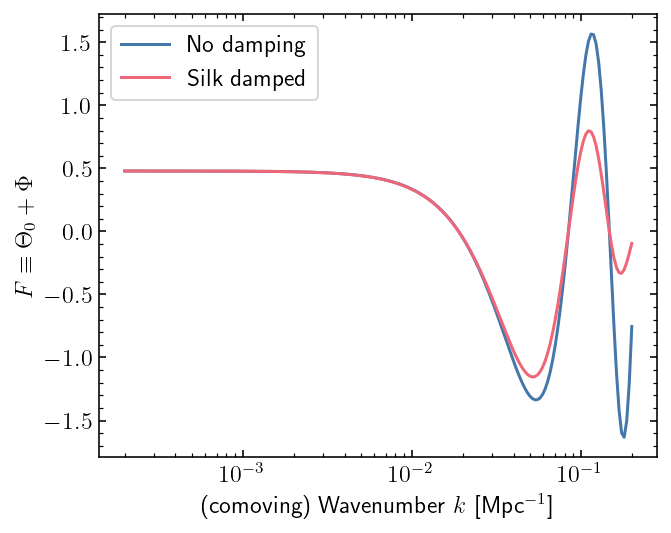

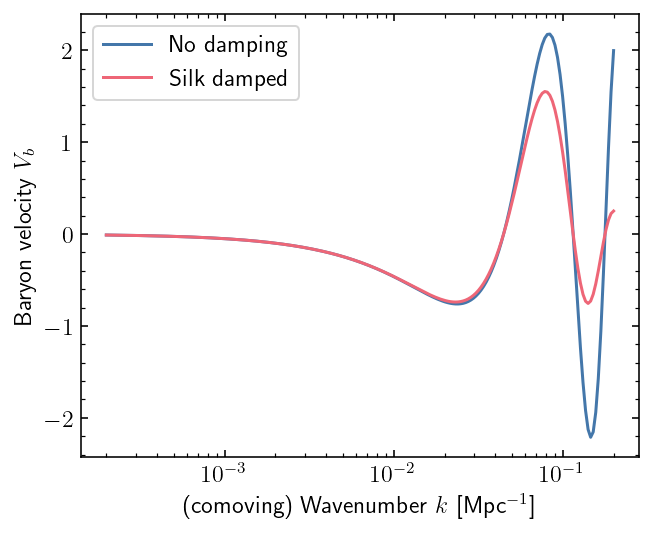

In [11]:
plt.plot(ks, Fs)
plt.plot(ks, Fs_damped)
plt.xscale('log')
plt.ylabel('$F \\equiv \\Theta_0 + \\Phi$')
plt.xlabel('(comoving) Wavenumber $k$ [Mpc$^{-1}$]')
plt.legend(['No damping', 'Silk damped'])
plt.show()

plt.plot(ks, Vbs)
plt.plot(ks, Vb_damped)
plt.xscale('log')
plt.ylabel('Baryon velocity $V_b$')
plt.xlabel('(comoving) Wavenumber $k$ [Mpc$^{-1}$]')
plt.legend(['No damping', 'Silk damped'])
plt.show()

In [12]:
ls = dedim(ks / (1 * u.Mpc**-1)) * 1e4

T_F0s = (2/3) * Fs_damped
T_Vbs = (2/3) * Vb_damped

A_s = 2e-9
n_s = 0.96
k_P = 0.05 * u.Mpc**-1

Delta_sq = A_s * dedim(ks / k_P)**(n_s - 1)

T0 = 2.73 * u.K
SW = (T_F0s**2 * T0**2 * Delta_sq).to(u.microKelvin**2)
Dop = (T_Vbs**2 / 3 * T0**2 * Delta_sq).to(u.microKelvin**2)

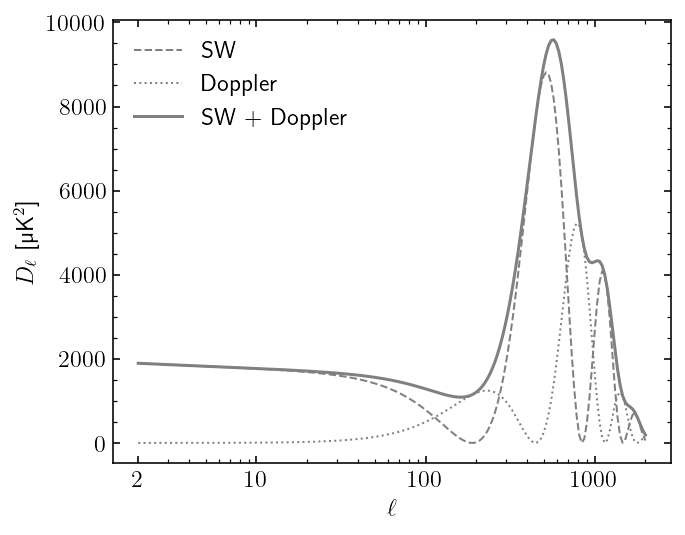

In [13]:
plt.plot(ls, SW, ls='--', lw=1, color='grey')
plt.plot(ls, Dop, ls=':', lw=1, color='grey')
plt.plot(ls, SW + Dop, ls='-', lw=1.5, color='grey')
plt.xscale('log')
plt.xlabel('$\\ell$')
plt.ylabel('$D_\\ell$ [µK$^2$]')
plt.xticks([2, 10, 100, 1000], ['$2$', '$10$', '$100$', '$1000$'])
plt.legend(['SW', 'Doppler', 'SW + Doppler'], frameon=False, loc='upper left')
plt.show()

This now looks pretty good, except...

- whole spectrum is shifted right
- whole spectrum is around twice its expected value
- SW and Doppler terms are so similar in height that we don't get a clear trough between the first and second peaks

These issues may just be expected since we have made several unphysical approximations to get here

In [14]:
from scipy.integrate import simpson

In [20]:
Dl = dedim((SW + Dop) / T0**2)

np.sqrt(simpson(Dl, x=np.log(ls)))

np.float64(4.8562091784257136e-05)